## Starbucks Capstone Challenge

# Introduction:

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

The given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

### Example:

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning:

This makes data cleaning especially important and tricky.

And also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.


# Data Sets:

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

# Data understanding:
### portfolio.json:

id (string) - offer id

offer_type (string) - type of offer ie BOGO, discount, informational

difficulty (int) - minimum required spend to complete an offer

reward (int) - reward given for completing an offer

duration (int) - time for offer to be open, in days

channels (list of strings)

### profile.json:

age (int) - age of the customer

became_member_on (int) - date when customer created an app account

gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)

id (str) - customer id

income (float) - customer's income

### transcript.json:

event (str) - record description (ie transaction, offer received, offer viewed, etc.)

person (str) - customer id

time (int) - time in hours since start of test. The data begins at time t=0

value - (dict of strings) - either an offer id or transaction amount depending on the record

# Problem Statement:

We will be exploring the Starbuck’s Dataset which simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.

There are three offers_types that can be sent: buy-one-get-one (BOGO), discount, and informational.

We will segment the customer data on different parameters and check its behavious on different offer_types using both supervised and unsupervised learning.

We will analyse the data in the Exploratory Data Analysis part of this section and answer the following questions related to customer segmentation and its buying behavious.


* What is the Gender Distribution of Starbucks Customers?
* What is the Age Distribution of Starbucks Customers?
* What is the Income Distribution of Starbucks Customers?
* How many customers enrolled yearly?
* Which gender has the highest yearly membership?
* Which gender has the highest Annual income?
* What is the distribution of event in transcripts?
* What is the percent of trasactions and offers in the event?
* What is the Income Distribution for the Offer Events?
* What are the Offer types amongst ages, gender and income groups?

# Data Preparing:

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sb
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error

from sklearn import preprocessing
from sklearn import cluster
from sklearn.cluster import KMeans

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## portfolio.json:

* portfolio dataset contains 10 records and 6 columns.  

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
print('minimum duration: ', portfolio.duration.min())
print('maximun duration: ',portfolio.duration.max())

minimum duration:  3
maximun duration:  10


In [7]:
print('mean reward value: ', portfolio.reward.mean())
print('median reward value: ',portfolio.reward.median())

mean reward value:  4.2
median reward value:  4.0


In [8]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [9]:
portfolio.offer_type.describe()

count       10
unique       3
top       bogo
freq         4
Name: offer_type, dtype: object

In [10]:
portfolio.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [11]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [12]:
portfolio.reward.value_counts()

5     3
10    2
2     2
0     2
3     1
Name: reward, dtype: int64

In [13]:
portfolio.duration.value_counts()

7     4
10    2
5     2
4     1
3     1
Name: duration, dtype: int64

In [14]:
portfolio.difficulty.value_counts()

10    4
5     2
0     2
7     1
20    1
Name: difficulty, dtype: int64

In [15]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [16]:
sum(portfolio.duplicated('id'))

0

In [17]:
print(portfolio.offer_type.nunique())
print(portfolio.offer_type.unique())

3
['bogo' 'informational' 'discount']


In [18]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [19]:
portfolio[['offer_type', 'difficulty', 'duration', 'reward']]

,offer_type,difficulty,duration,reward
0,bogo,10,7,10
1,bogo,10,5,10
2,informational,0,4,0
3,bogo,5,7,5
4,discount,20,10,5
5,discount,7,7,3
6,discount,10,10,2
7,informational,0,3,0
8,bogo,5,5,5
9,discount,10,7,2


In [20]:
for ele in range(portfolio.shape[0]):
    row = portfolio.iloc[ele]
    print(" offer-{}:-- {}:difficulty, {}:duration, {}:reward ".format(row['offer_type'], row['difficulty'], row['duration'], row['reward']))

 offer-bogo:-- 10:difficulty, 7:duration, 10:reward 
 offer-bogo:-- 10:difficulty, 5:duration, 10:reward 
 offer-informational:-- 0:difficulty, 4:duration, 0:reward 
 offer-bogo:-- 5:difficulty, 7:duration, 5:reward 
 offer-discount:-- 20:difficulty, 10:duration, 5:reward 
 offer-discount:-- 7:difficulty, 7:duration, 3:reward 
 offer-discount:-- 10:difficulty, 10:duration, 2:reward 
 offer-informational:-- 0:difficulty, 3:duration, 0:reward 
 offer-bogo:-- 5:difficulty, 5:duration, 5:reward 
 offer-discount:-- 10:difficulty, 7:duration, 2:reward 


## profile.json:

* profile dataset contains 17000 records and 5 columns.

In [21]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [22]:
profile.shape

(17000, 5)

In [23]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [24]:
print('mean income value: ', profile.income.mean())
print('median income value: ', profile.income.median())

mean income value:  65404.9915683
median income value:  64000.0


In [25]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [26]:
profile.describe(include = 'object')

,gender,id
count,14825,17000
unique,3,17000
top,M,f3fd1aa25b3248c1a0fcd3299562cd65
freq,8484,1


In [27]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [28]:
profile.sample(5)

,age,became_member_on,gender,id,income
5218,76,20150921,M,78d968c803724eb5812a988d5156f943,44000.0
15613,61,20180123,F,a37ef87a1322462a979924829b3e747b,105000.0
11797,21,20140501,M,1f01b421fdb14346ba1efa9a8884d3d0,42000.0
824,66,20180118,M,96ce002a049e41e6b0f4da541ea71f3e,74000.0
8399,30,20180108,M,d2cbcf6fac5b47149b822875c3c08898,47000.0


In [29]:
sum(profile.duplicated())

0

In [30]:
sum(profile.id.duplicated())

0

In [31]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [32]:
profile.became_member_on.nunique()

1716

In [33]:
profile.age.nunique()

85

In [34]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [35]:
age_118 = profile[profile.age == 118].count()
age_118

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [36]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [37]:
profile.groupby('gender')['age'].count()

gender
F    6129
M    8484
O     212
Name: age, dtype: int64

In [38]:
profile.groupby('gender')['age'].mean()

gender
F    57.544950
M    52.116690
O    54.400943
Name: age, dtype: float64

In [39]:
profile.groupby('gender')['income'].mean()

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64

In [40]:
profile.age.mean()

62.531411764705879

In [41]:
profile.income.mean()

65404.991568296799

In [42]:
profile.id.nunique()

17000

## transcript.json:

* transcript dataset contains 306534 records and 4 columns.

In [43]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [44]:
transcript.shape

(306534, 4)

In [45]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [46]:
print('mean time value: ', transcript.time.mean())
print('median time value: ',transcript.time.median())

mean time value:  366.382939576
median time value:  408.0


In [47]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [48]:
transcript.describe(include = 'object')

,event,person,value
count,306534,306534,306534
unique,4,17000,5121
top,transaction,94de646f7b6041228ca7dec82adb97d2,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
freq,138953,51,14983


In [49]:
transcript.sample(5)

,event,person,time,value
1599,offer received,1a9cc4b4f763429b9cb006bd78cd7a7b,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
50176,transaction,77fef96c3b8a4a89a43c4127b9b23adf,144,{'amount': 18.75}
231060,transaction,82dba81cc2c04623bb1cf3c0b1fe8e17,534,{'amount': 38.56}
224959,transaction,2b3a88b3ad454a72aa4392569307f6ff,516,{'amount': 7.69}
251421,offer received,2d4eaf25aa8f45ffbbcebcce5082cad2,576,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [50]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [51]:
sum(transcript.person.duplicated())

289534

In [52]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [53]:
transcript.event.nunique()

4

In [54]:
transcript.value.head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [55]:
transcript.person.nunique()

17000

In [56]:
received = transcript.query(" event == 'offer received' ")['time'].mean()
completed = transcript.query(" event == 'offer completed' ")['time'].mean()
viewed = transcript.query(" event == 'offer viewed' ")['time'].mean()
transactions = transcript.query(" event == 'transaction' ")['time'].mean()

print('mean time of offer received:', received)
print('mean time of offer viewed:', viewed)
print('mean time of offer completed:', completed)
print('mean time of transactions:', transactions)

mean time of offer received: 332.579519383
mean time of offer viewed: 354.290515375
mean time of offer completed: 401.052800858
mean time of transactions: 381.584334271


In [57]:
received = transcript.query(" event == 'offer received' ")['time'].count()
completed = transcript.query(" event == 'offer completed' ")['time'].count()
viewed = transcript.query(" event == 'offer viewed' ")['time'].count()
transactions = transcript.query(" event == 'transaction' ")['time'].count()

print('offer received counts:', received)
print('offer viewed counts:', viewed)
print('offer completed counts:', completed)
print('transactions counts:', transactions)

offer received counts: 76277
offer viewed counts: 57725
offer completed counts: 33579
transactions counts: 138953


In [58]:
transcript.time.nunique()

120

In [59]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

In [60]:
transcript.query(" event == 'transaction' ")

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}
12678,transaction,629fc02d56414d91bca360decdfa9288,0,{'amount': 33.9}
12686,transaction,bbeb54e861614fc7b22a8844f72dca6c,0,{'amount': 0.22}
12687,transaction,a97e6f33219c432db82acfa0d19c602d,0,{'amount': 18.59}
12691,transaction,676506bad68e4161b9bbaffeb039626b,0,{'amount': 18.01}
12696,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'amount': 19.11}


In [61]:
transcript.query(" event == 'offer completed' ")

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12717,offer completed,227f2d69e46a4899b70d48182822cff6,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12721,offer completed,bb0f25e23a4c4de6a645527c275cd594,0,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
12744,offer completed,d72d201be5794279aa716d8ad82b8d90,0,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
12764,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12767,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


# Data Pre-processing:

## pre processing portfolio dataset:

* rename id column.
* one hot encode for channel column.

In [62]:
# rename the id columns for ease of understanding:

portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

In [63]:


# One-hot encode : channels column:

portfolio['email'] = portfolio['channels'].apply(lambda ele: 1 if 'email' in ele else 0)
portfolio['web'] = portfolio['channels'].apply(lambda ele: 1 if 'web' in ele else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda ele: 1 if 'mobile' in ele else 0)
portfolio['social'] = portfolio['channels'].apply(lambda ele: 1 if 'social' in ele else 0)

In [64]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_id      10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
email         10 non-null int64
web           10 non-null int64
mobile        10 non-null int64
social        10 non-null int64
dtypes: int64(7), object(3)
memory usage: 880.0+ bytes


In [65]:
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,email,web,mobile,social
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


## Exploratory Data Analysis for portfolio dataset:

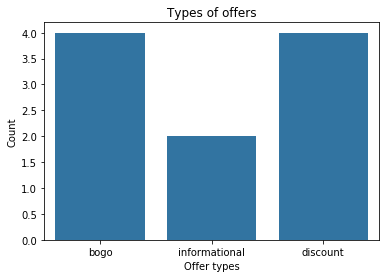

In [66]:
# types of offers:

color = sb.color_palette()[0]

sb.countplot(data = portfolio, x = 'offer_type', color = color);
plt.title('Types of offers');
plt.ylabel('Count');
plt.xlabel('Offer types');

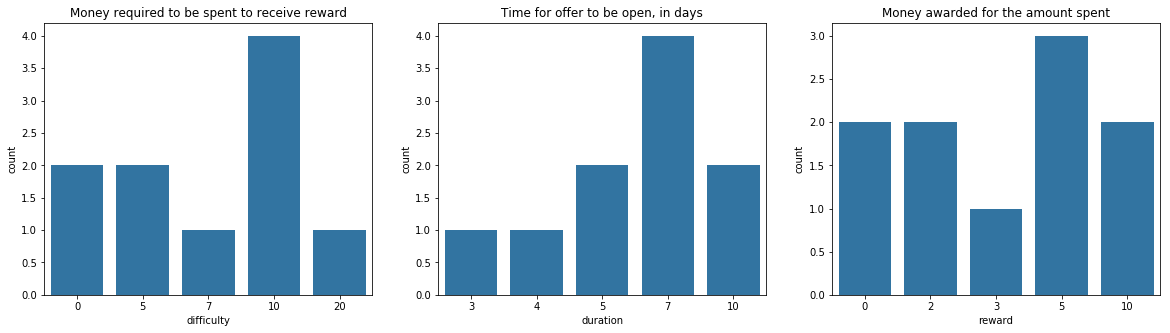

In [67]:
# Creating Subplots for distribution based on difficulty, duration, reward for portfolio data.

plt.figure(figsize = [20,5])

color = sb.color_palette()[0]
plt.subplot(1,3,1)

sb.countplot(data = portfolio, x = 'difficulty', color = color);
plt.title('Money required to be spent to receive reward');
plt.ylabel('count');
plt.xlabel('difficulty');

plt.subplot(1,3,2)
sb.countplot(data = portfolio, x = 'duration', color = color);
plt.title('Time for offer to be open, in days');
plt.ylabel('count');
plt.xlabel('duration');

plt.subplot(1,3,3)
sb.countplot(data = portfolio, x = 'reward', color = color);
plt.title('Money awarded for the amount spent');
plt.ylabel('count');
plt.xlabel('reward');

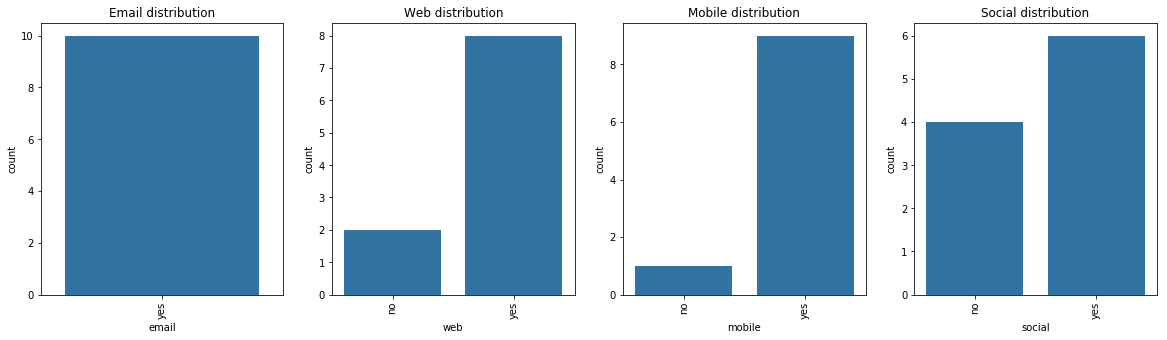

In [68]:
# Creating Subplots for distribution based on email, web, mobile and social for portfolio data.

plt.figure(figsize = [20,5])

color = sb.color_palette()[0]

plt.subplot(1,4,1)
x = sb.countplot(data = portfolio, x = 'email', color = color);
plt.title('Email distribution');
plt.ylabel('count');
plt.xlabel('email');
xlabels = ['yes', 'no']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

plt.subplot(1,4,2)
x = sb.countplot(data = portfolio, x = 'web', color = color);
plt.title('Web distribution');
plt.ylabel('count');
plt.xlabel('web');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

plt.subplot(1,4,3)
x = sb.countplot(data = portfolio, x = 'mobile', color = color);
plt.title('Mobile distribution');
plt.ylabel('count');
plt.xlabel('mobile');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

plt.subplot(1,4,4)
x = sb.countplot(data = portfolio, x = 'social', color = color);
plt.title('Social distribution');
plt.ylabel('count');
plt.xlabel('social');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

## pre processing profile dataset:

* check the age column for extreme values (118)
* create readable date format in became_member_on column
* extract its year, month and day from became_member_on column add to columns (for further analysis)
* create new column grouped with age group
* create new column grouped with salary group
* fillna with median values and change its datatype
* rename the id columns for ease of understanding
* create new column grouped with member_since group:

In [69]:
# check the age column for extreme values (118) and replace it with 0:

profile['age'] = profile['age'].apply(lambda ele: 0 if ele == 118 else ele)

In [70]:
# fill median values to income

profile['income'].fillna((profile['income'].median()), inplace=True)

In [71]:
# change income datatype:

profile['income'] = profile['income'].astype('int')

In [72]:
# rename the id columns for ease of understanding:

profile.rename(columns = {'id': 'customer_id'}, inplace = True)

In [73]:
# create new column grouped with age group:

def Ages(ele):
        if ele < 20:
            return 1
        elif 21 < ele <= 30:
            return 2
        elif 31 <= ele <= 40:
            return 3
        elif 41 <= ele <= 50:
            return 4
        elif 51 <= ele <= 60:
            return 5
        elif 61 <= ele <= 70:
            return 6
        elif 71 <= ele <= 80:
            return 7
        elif 81 <= ele <= 90:
            return 8
        elif 91 <= ele <= 101:
            return 9
        else:
            return 10
            
profile['age_groups'] = profile['age'].apply(Ages)

In [74]:
# create new column grouped with salary group:

def Salarys(ele):
        if ele < 30000:
            return 1
        elif 30001 < ele <= 40000:
            return 2
        elif 40001 <= ele <= 50000:
            return 3
        elif 50001 <= ele <= 60000:
            return 4
        elif 60001 <= ele <= 70000:
            return 5
        elif 70001 <= ele <= 80000:
            return 6
        elif 80001 <= ele <= 90000:
            return 7
        elif 90001 <= ele <= 100000:
            return 8
        elif 100001 <= ele <= 110000:
            return 9
        elif 110001 <= ele <= 120000:
            return 10
        elif 120001 <= ele <= 150000:
            return 10
        else:
            return 0
            
profile['salary_groups'] = profile['income'].apply(Salarys)

In [75]:
# extract its year, month and day from became_member_on column add to columns (for further analysis):

profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['member_year'] = profile['became_member_on'].dt.year
profile['member_month'] = profile['became_member_on'].dt.month
profile['member_day'] = profile['became_member_on'].dt.day

In [76]:
# create readable date format in became_member_on column:

import datetime

profile['members_since_in_days'] = datetime.datetime.today().date() - profile['became_member_on'].dt.date
profile['members_since_in_days'] = profile['members_since_in_days'].dt.days

In [77]:
# create new column grouped with member_since group:

def Year(ele):
    if 744 <= ele <= 3*365:
        return 2
    elif 3*365 <= ele <= 4*365:
        return 3
    elif 4*365 <= ele <= 5*365:
        return 4
    elif 5*365 <= ele <= 6*365:
        return 5
    elif 6*365 <= ele <= 7*365:
        return 6
    elif 7*365 <= ele <= 8*365:
        return 7
    elif 8*365 <= ele <= 9*365:
        return 8
    else:
        return 0
            
profile['member_since_year'] = profile['members_since_in_days'].apply(Year)

In [78]:
# Remove null values:

profile.dropna(inplace = True)

In [79]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 12 columns):
age                      14825 non-null int64
became_member_on         14825 non-null datetime64[ns]
gender                   14825 non-null object
customer_id              14825 non-null object
income                   14825 non-null int64
age_groups               14825 non-null int64
salary_groups            14825 non-null int64
member_year              14825 non-null int64
member_month             14825 non-null int64
member_day               14825 non-null int64
members_since_in_days    14825 non-null int64
member_since_year        14825 non-null int64
dtypes: datetime64[ns](1), int64(9), object(2)
memory usage: 1.5+ MB


In [80]:
profile.head()

,age,became_member_on,gender,customer_id,income,age_groups,salary_groups,member_year,member_month,member_day,members_since_in_days,member_since_year
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,5,10,2017,7,15,1563,4
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,7,8,2017,5,9,1630,4
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000,6,5,2018,4,26,1278,3
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000,6,4,2018,2,9,1354,3
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000,5,4,2017,11,11,1444,3


## Exploratory Data Analysis for profile dataset:

* What is the Gender Distribution of Starbucks Customers?
* What is the Age Distribution of Starbucks Customers?
* What is the Income Distribution of Starbucks Customers?

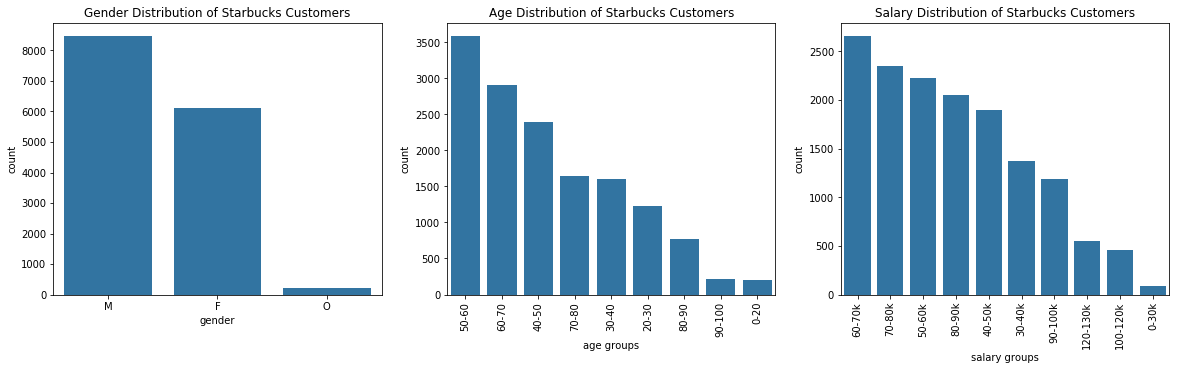

In [81]:
# Creating Subplots for distribution based on gender, age_groups, salary_groups for the cleaned Profile data:

plt.figure(figsize = [20,5])

color = sb.color_palette()[0]
plt.subplot(1,3,1)
order = ['M',  'F',  'O']
sb.countplot(data = profile, x = 'gender', color = color, order = order);
plt.title('Gender Distribution of Starbucks Customers');
plt.ylabel('count');
plt.xlabel('gender');

plt.subplot(1,3,2)
order = [5, 6, 4, 7, 3, 2, 8, 9, 1]
x = sb.countplot(data = profile, x = 'age_groups', color = color, order = order);
plt.title('Age Distribution of Starbucks Customers');
plt.ylabel('count');
plt.xlabel('age groups');
xlabels = ['50-60', '60-70', '40-50', '70-80', '30-40', '20-30', '80-90', '90-100', '0-20']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

plt.subplot(1,3,3)
order = [4, 5, 6, 2, 3, 7, 8, 9, 10, 0]
x = sb.countplot(data = profile, x = 'salary_groups', color = color, order = order);
plt.title('Salary Distribution of Starbucks Customers');
plt.ylabel('count');
plt.xlabel('salary groups');
xlabels = ['60-70k', '70-80k', '50-60k', '80-90k', '40-50k', '30-40k', '90-100k', '120-130k', '100-120k', '0-30k']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

According to graph,
1. The proprtion of males(around 9000) is slightly more than those of the females(around 6000) and very small amount of others.
2. Age group range from 40-70 frequently visits starbucks.
3. There is a decrease in the number of customers as after 70K, mentioning as the income increases people spend less on coffee.

* How many customers enrolled yearly ?

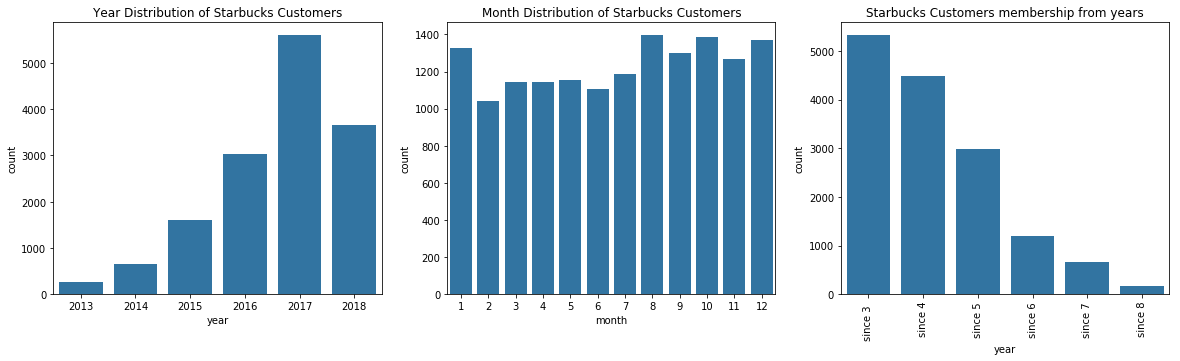

In [82]:
# Creating Subplots for distribution based on year, month, member_since for the cleaned Profile data:

plt.figure(figsize = [20,5])

color = sb.color_palette()[0]
plt.subplot(1,3,1)
sb.countplot(data = profile, x = 'member_year', color = color);
plt.title('Year Distribution of Starbucks Customers');
plt.ylabel('count');
plt.xlabel('year');

plt.subplot(1,3,2)
sb.countplot(data = profile, x = 'member_month', color = color);
plt.title('Month Distribution of Starbucks Customers');
plt.ylabel('count');
plt.xlabel('month');

plt.subplot(1,3,3)
x = sb.countplot(data = profile, x = 'member_since_year', color = color);
plt.title('Starbucks Customers membership from years');
plt.ylabel('count');
plt.xlabel('year');
xlabels = ['since 3 ', 'since 4', 'since 5', 'since 6', 'since 7', 'since 8']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

According to graph, Members of the starbucks increased exponentially from 2013 and reached its highest in 2017 which later declines steadily.

* Which gender has the highest yearly membership?

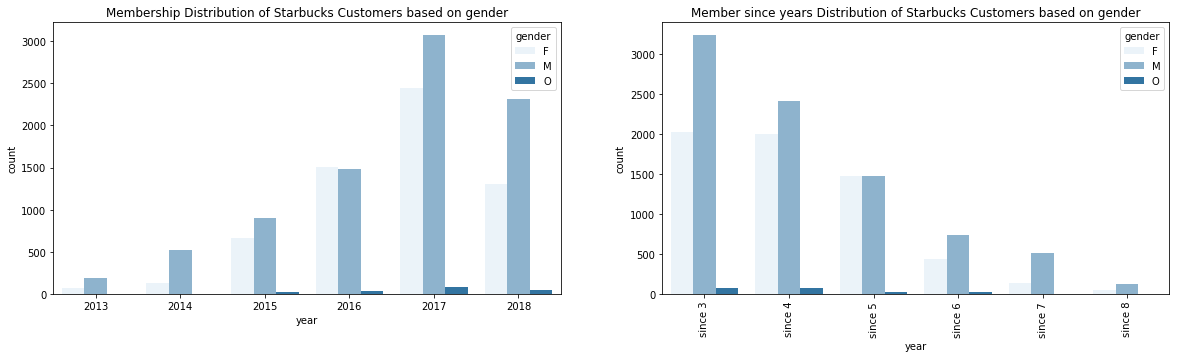

In [83]:
# Visualize distribution of membership years grouped by success:

plt.figure(figsize = [20,5])
color = sb.color_palette()[0]

plt.subplot(1,2,1)
sb.countplot(data = profile, x = 'member_year', hue = 'gender', color = color);
plt.title('Membership Distribution of Starbucks Customers based on gender');
plt.ylabel('count');
plt.xlabel('year');

plt.subplot(1,2,2)
x = sb.countplot(data = profile, x = 'member_since_year', hue = 'gender', color = color);
plt.title('Member since years Distribution of Starbucks Customers based on gender');
plt.ylabel('count');
plt.xlabel('year');
xlabels = ['since 3', 'since 4', 'since 5', 'since 6', 'since 7', 'since 8']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

According to graph, With the increase in popularity of starbucks, people have joined starbucks yearly exponentially and reached its zenith in 2017.
More men have joined than the female and very few from others every year.

* Which gender has the highest Annual income?

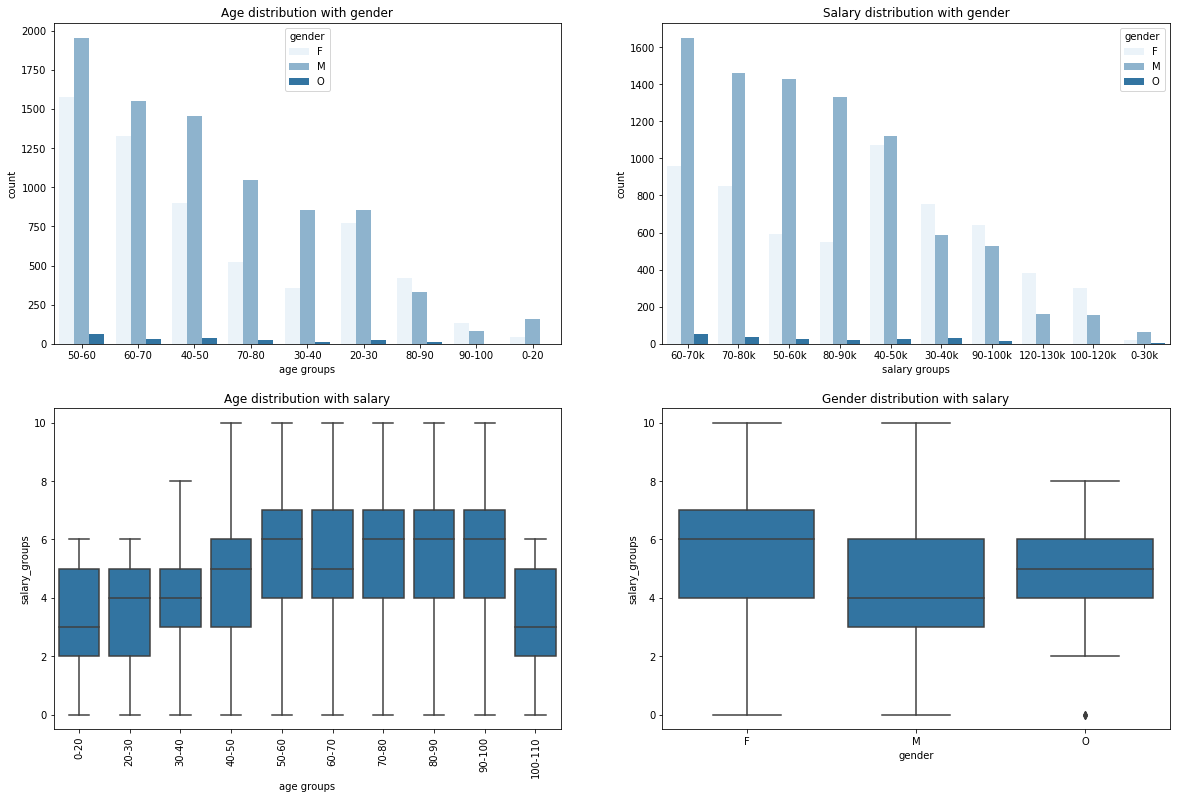

In [84]:
# Visualize distribution of age, salarys with gender:

plt.subplots(2, 2, figsize=(20, 13))
color = sb.color_palette()[0]


plt.subplot(2,2,1)
order = [5, 6, 4, 3, 2, 7, 8, 9, 1]
x = sb.countplot(data = profile, x = 'age_groups', order = order, hue = 'gender', color = color);
plt.title('Age distribution with gender');
plt.ylabel('count');
plt.xlabel('age groups');
xlabels = ['50-60', '60-70', '40-50', '70-80', '30-40', '20-30', '80-90', '90-100', '0-20']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(2,2,2)
order = [4, 5, 2, 3, 6, 7, 8, 9, 10, 0]
x = sb.countplot(data = profile, x = 'salary_groups', order = order, hue = 'gender', color = color);
plt.title('Salary distribution with gender');
plt.ylabel('count');
plt.xlabel('salary groups');
xlabels = ['60-70k', '70-80k', '50-60k', '80-90k', '40-50k', '30-40k', '90-100k', '120-130k', '100-120k', '0-30k']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

# Visualize distribution of age v/s salarys and salary v/s gender:

plt.subplot(2,2,3)
x = sb.boxplot(data = profile, x = 'age_groups', y = 'salary_groups', color = color);
plt.title('Age distribution with salary');
plt.ylabel('salary_groups');
plt.xlabel('age groups');
xlabels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-110']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

plt.subplot(2,2,4)
sb.boxplot(data = profile, x = 'gender', y = 'salary_groups', color = color);
plt.title('Gender distribution with salary');
plt.ylabel('salary_groups');
plt.xlabel('gender');

According to graph, The income for females(around 70k) is higher than males and others.

The count of male customers in low-income level is slightly higher than that of female and other customers

## pre processing transcript dataset:

* rename the id columns for ease of understanding.
* Create new columns offer_id, amount and reward from value column.
* Replace null value with 0 to amount column.
* Drop value column.
* One hot encode for event column.

In [85]:
# rename the id columns for ease of understanding:

transcript.rename(columns = {'person': 'customer_id'}, inplace = True)

In [86]:

# Create new columns offer_id, amount and reward from value column:

import ast

for ele in transcript['value']:
    try:
        ele['offer_id'] = ele.pop('offer id')
    except:
        pass

# Create separate columns for amount and offer_id and reward from value col dictionary:
data = pd.DataFrame([ast.literal_eval(json.dumps(ele)) for ele in transcript.value.values])

transcript = pd.concat([transcript, data], axis = 1)

In [87]:
# Replace null value with 0 to amount column:

transcript.amount = transcript.amount.replace({np.nan: 0})

In [88]:
#  Drop value column:

transcript.drop('value', axis = 1, inplace = True)

In [89]:

# one hot encode for event column:

df = pd.get_dummies(transcript['event'])

transcript = pd.concat([df, transcript], axis = 1, sort = False)

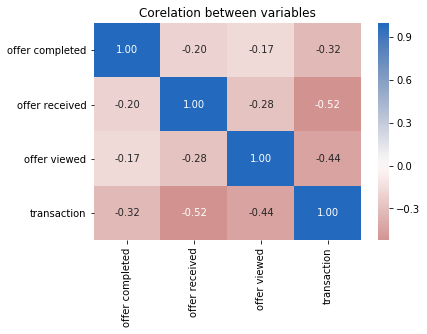

In [90]:
# Heatmap for events:

sb.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)
plt.title('Corelation between variables');

There is no relationship between types of events. negative corelation between them.

In [91]:
# Rename column names:

transcript.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_recived', 'offer viewed': 'offer_viewed'}, inplace = True)

In [92]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 10 columns):
offer_completed    306534 non-null uint8
offer_recived      306534 non-null uint8
offer_viewed       306534 non-null uint8
transaction        306534 non-null uint8
event              306534 non-null object
customer_id        306534 non-null object
time               306534 non-null int64
amount             306534 non-null float64
offer_id           167581 non-null object
reward             33579 non-null float64
dtypes: float64(2), int64(1), object(3), uint8(4)
memory usage: 15.2+ MB


In [93]:
transcript.head()

,offer_completed,offer_recived,offer_viewed,transaction,event,customer_id,time,amount,offer_id,reward
0,0,1,0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,0,1,0,0,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,0,1,0,0,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,2906b810c7d4411798c6938adc9daaa5,NaN
3,0,1,0,0,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,0,1,0,0,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


## Exploratory Data Analysis for transcript dataset:

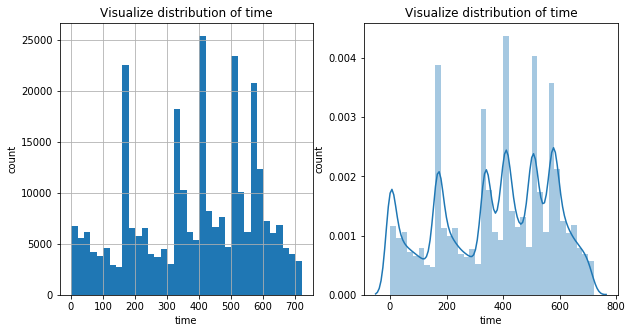

In [94]:
# Visualize distribution of time:

plt.figure(figsize = [10,5])
color = sb.color_palette()[0]
bins = np.arange(1, transcript['time'].max()+20, 20)

plt.subplot(1,2,1)
transcript.time.hist(bins = bins);
plt.title('Visualize distribution of time');
plt.ylabel('count');
plt.xlabel('time');

plt.subplot(1,2,2)
sb.distplot(transcript.time, bins = bins)
plt.title('Visualize distribution of time');
plt.ylabel('count');
plt.xlabel('time');

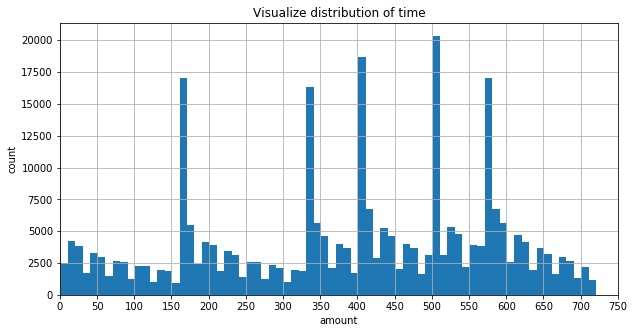

In [95]:
# Visualize distribution of amount:

plt.figure(figsize = [10,5])
color = sb.color_palette()[0]
bins = np.arange(1, transcript['amount'].max()+10, 10)

transcript.time.hist(bins = bins);
plt.title('Visualize distribution of time');
plt.ylabel('count');
plt.xlabel('amount');
tick = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750]
label = ['{}'.format(ele) for ele in tick]
plt.xticks(tick, label);
plt.xlim((0,750));

* What is the distribution of event in transcripts?
* What is the percent of trasactions and offers in the event?

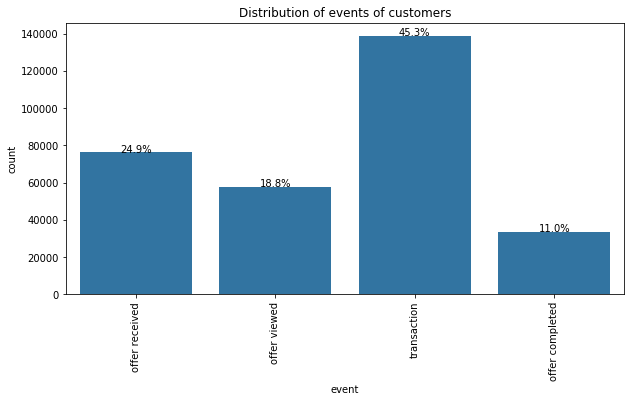

In [96]:
# Visualize distribution of events:

plt.figure(figsize = [10,5])
color = sb.color_palette()[0]

sb.countplot(data = transcript, x = 'event', color = color);
plt.title('Distribution of events of customers');
plt.ylabel('count');
plt.xlabel('event');

value_sum = transcript['event'].value_counts().sum()
value = transcript['event'].value_counts()

locs, labels = plt.xticks(rotation = 90) 

for loc, label in zip(locs, labels):

    count = value[label.get_text()]
    text = '{:0.1f}%'.format(100 * count/value_sum)

    plt.text(loc, count+2, text, ha = 'center', color = 'black');

According to graph, We can see that most of the transcripts are transactions.

Nearly 45.3% are transactions and 54.7% are offers.

* What is the distribution of event in transcripts?
* What is the percent of trasactions and offers in the event?

In [97]:
new = transcript[transcript['event'] != 'transaction']
new = pd.DataFrame(new)
new.head()

,offer_completed,offer_recived,offer_viewed,transaction,event,customer_id,time,amount,offer_id,reward
0,0,1,0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,0,1,0,0,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,0,1,0,0,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,2906b810c7d4411798c6938adc9daaa5,NaN
3,0,1,0,0,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,0,1,0,0,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


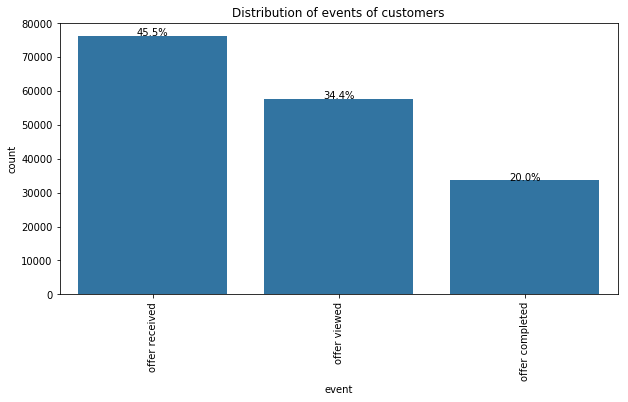

In [98]:
# Visualize distribution of events without transcations count:

plt.figure(figsize = [10,5])
color = sb.color_palette()[0]

sb.countplot(data = new, x = new['event'], color = color);
plt.title('Distribution of events of customers');
plt.ylabel('count');
plt.xlabel('event');

value_sum = new['event'].value_counts().sum()
value = new['event'].value_counts()
locs, labels = plt.xticks(rotation = 90) 

for loc, label in zip(locs, labels):

    count = value[label.get_text()]
    text = '{:0.1f}%'.format(100 * count/value_sum)

    plt.text(loc, count+2, text, ha = 'center', color = 'black');

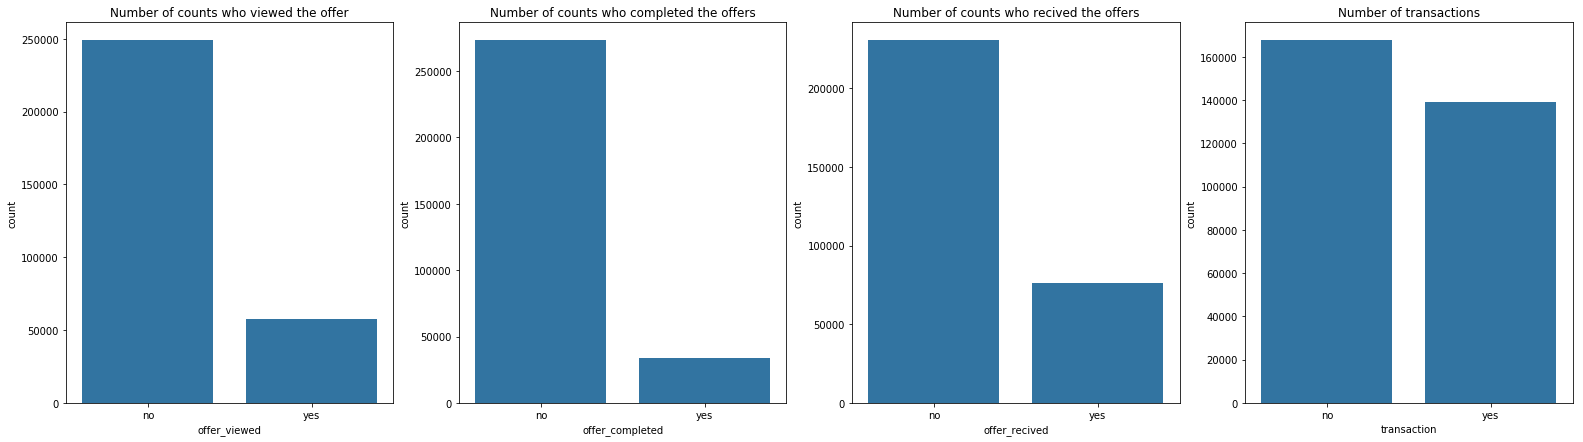

In [99]:
# Graph for Number of counts who recived, viewed, completed the offers:

plt.figure(figsize = [27,7])
color = sb.color_palette()[0]

plt.subplot(1,4,1)
x = sb.countplot(data = transcript, x = 'offer_viewed', color = color);
plt.title('Number of counts who viewed the offer');
plt.ylabel('count');
plt.xlabel('offer_viewed');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(1,4,2)
x = sb.countplot(data = transcript, x = 'offer_completed', color = color);
plt.title('Number of counts who completed the offers');
plt.ylabel('count');
plt.xlabel('offer_completed');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(1,4,3)
x = sb.countplot(data = transcript, x = 'offer_recived', color = color);
plt.title('Number of counts who recived the offers');
plt.ylabel('count');
plt.xlabel('offer_recived');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(1,4,4)
x = sb.countplot(data = transcript, x = 'transaction', color = color);
plt.title('Number of transactions');
plt.ylabel('count');
plt.xlabel('transaction');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

## Merge the three data sets with common columns into one for futhur analysis:

In [100]:
# merge the transcript and profile dataframes on customer_id column:

data = transcript.merge(profile, on = ['customer_id'])

In [101]:
data.shape

(272762, 21)

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 21 columns):
offer_completed          272762 non-null uint8
offer_recived            272762 non-null uint8
offer_viewed             272762 non-null uint8
transaction              272762 non-null uint8
event                    272762 non-null object
customer_id              272762 non-null object
time                     272762 non-null int64
amount                   272762 non-null float64
offer_id                 148805 non-null object
reward                   32444 non-null float64
age                      272762 non-null int64
became_member_on         272762 non-null datetime64[ns]
gender                   272762 non-null object
income                   272762 non-null int64
age_groups               272762 non-null int64
salary_groups            272762 non-null int64
member_year              272762 non-null int64
member_month             272762 non-null int64
member_day               27

In [103]:
# merge the transcript and portfolio  on customer_id column using left join:

new_data = data.merge(portfolio, on = ['offer_id'], how = 'left')

In [104]:
new_data.shape

(272762, 30)

* After merging the three data sets, the final new_data set contains 272762 rows and 30 colomns.

In [105]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 30 columns):
offer_completed          272762 non-null uint8
offer_recived            272762 non-null uint8
offer_viewed             272762 non-null uint8
transaction              272762 non-null uint8
event                    272762 non-null object
customer_id              272762 non-null object
time                     272762 non-null int64
amount                   272762 non-null float64
offer_id                 148805 non-null object
reward_x                 32444 non-null float64
age                      272762 non-null int64
became_member_on         272762 non-null datetime64[ns]
gender                   272762 non-null object
income                   272762 non-null int64
age_groups               272762 non-null int64
salary_groups            272762 non-null int64
member_year              272762 non-null int64
member_month             272762 non-null int64
member_day               27

* Dataframe consisting of all the data related to Offers are seperated in to (offer_data)
* Dataframe consisting of all the data related to Transactions are seperated in to (transaction_data).

In [106]:
# Seperate the three offer columns from the transaction column

transaction_df = new_data[new_data['event'] == 'transaction']
transaction_df.head()

,offer_completed,offer_recived,offer_viewed,transaction,event,customer_id,time,amount,offer_id,reward_x,...,member_since_year,channels,difficulty,duration,offer_type,reward_y,email,web,mobile,social
2,0,0,0,1,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,NaN,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,1,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,NaN,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,0,0,1,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,19.67,NaN,NaN,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,0,1,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,29.72,NaN,NaN,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,0,0,1,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,23.93,NaN,NaN,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
transaction_df.shape

(123957, 30)

In [108]:
# Seperate the three offer columns from the transaction column

offer_df = new_data[new_data['transaction'] != 1]
offer_df.head()

,offer_completed,offer_recived,offer_viewed,transaction,event,customer_id,time,amount,offer_id,reward_x,...,member_since_year,channels,difficulty,duration,offer_type,reward_y,email,web,mobile,social
0,0,1,0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,4,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,0,0,1,0,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,4,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
3,1,0,0,0,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,...,4,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
5,0,1,0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,0.0,5a8bc65990b245e5a138643cd4eb9837,NaN,...,4,"[email, mobile, social]",0.0,3.0,informational,0.0,1.0,0.0,1.0,1.0
6,0,0,1,0,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,0.0,5a8bc65990b245e5a138643cd4eb9837,NaN,...,4,"[email, mobile, social]",0.0,3.0,informational,0.0,1.0,0.0,1.0,1.0


In [109]:
offer_df.shape

(148805, 30)

In [110]:
print('mean time value: ', offer_df.time.mean())
print('median time value: ',offer_df.time.median())

mean time value:  354.570222775
median time value:  408.0


In [111]:
print('mean age value: ', offer_df.age.mean())
print('median age value: ',offer_df.age.median())
print('total age value: ', offer_df.age.sum())
print('maximum age value: ',offer_df.age.max())
print('minimum age value: ',offer_df.age.min())

mean age value:  54.7792816102
median age value:  56.0
total age value:  8151431
maximum age value:  101
minimum age value:  18


In [112]:
# Rearrange the offer_id dataset and del columns:

offer_df.reset_index(inplace=True)
del offer_df['index']

In [113]:
# Drop columns:

offer_df.drop(['channels', 'transaction', 'amount', 'reward_x'], axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Data Labelling:

* Label the columns - offer_id. offer_type, gender, and the unique customer_ids

In [114]:
from sklearn import preprocessing

# label encoding - offer_id (10 different IDs) from the portfolio data set:

le_1 = preprocessing.LabelEncoder()
le_1.fit(portfolio['offer_id'])

offer_df['offer_id'] = le_1.fit_transform(offer_df['offer_id'].astype(str))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [115]:
# label encoding - offer_type from the portfolio data set (3 different types, bogo-discount-informational):

le_2 = preprocessing.LabelEncoder()
le_2.fit(portfolio.offer_type)

offer_df['offer_type'] = le_2.fit_transform(offer_df['offer_type'].astype(str))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [116]:
# label encoding for gender from the profile data set(3 different types, male-female-other):

le_3 = preprocessing.LabelEncoder()
le_3.fit(profile['gender'])

offer_df['gender'] = le_3.fit_transform(offer_df['gender'].astype(str))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [117]:
# label the unique customer ids, create a mapper function to avoid duplication:

def id_mapper():
    """
    INPUT: 
    col_name (str): name of the column whose values are to be changed
    
    OUTPUT:
    id_encoded (list): list of the mapped integers for each value
    
    Description:
    This function will map integers to such '912b9f623b9e4b4eb99b6dc919f09a93' long values.
    
    """
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in offer_df['customer_id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded

id_encoded = id_mapper()
del offer_df['customer_id']
offer_df['customer_ids'] = id_encoded

# show header
offer_df.sample(5)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,offer_completed,offer_recived,offer_viewed,event,time,offer_id,age,became_member_on,gender,income,...,member_since_year,difficulty,duration,offer_type,reward_y,email,web,mobile,social,customer_ids
53441,0,1,0,offer received,168,1,61,2015-12-19,2,69000,...,5,7.0,7.0,1,3.0,1.0,1.0,1.0,1.0,5026
66626,0,1,0,offer received,408,2,47,2017-12-21,0,65000,...,3,10.0,7.0,1,2.0,1.0,1.0,1.0,0.0,6282
28462,1,0,0,offer completed,564,7,38,2018-05-17,0,59000,...,3,10.0,7.0,0,10.0,1.0,0.0,1.0,1.0,2678
107219,1,0,0,offer completed,282,1,36,2017-10-28,1,73000,...,3,7.0,7.0,1,3.0,1.0,1.0,1.0,1.0,10128
36339,0,1,0,offer received,408,0,51,2016-04-13,0,72000,...,5,20.0,10.0,1,5.0,1.0,1.0,0.0,0.0,3421


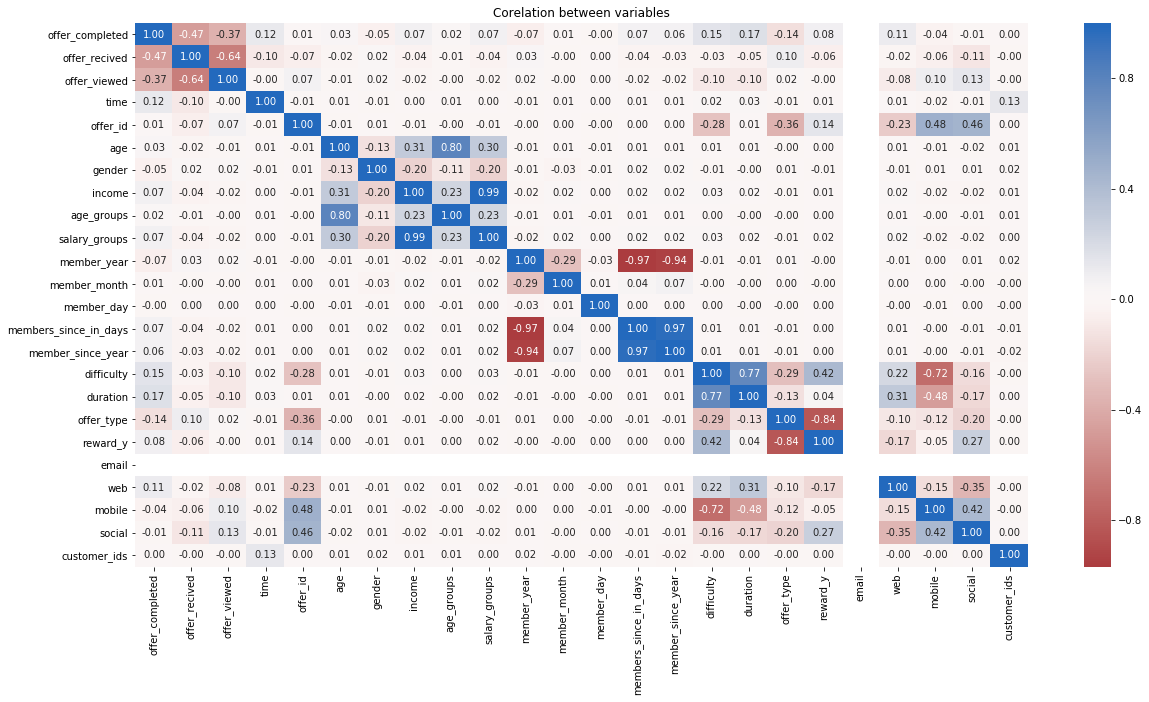

In [118]:
# heat map for cleaned dataset:

plt.figure(figsize = [20,10])

sb.heatmap(offer_df.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)
plt.title('Corelation between variables');

In [119]:
offer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148805 entries, 0 to 148804
Data columns (total 26 columns):
offer_completed          148805 non-null uint8
offer_recived            148805 non-null uint8
offer_viewed             148805 non-null uint8
event                    148805 non-null object
time                     148805 non-null int64
offer_id                 148805 non-null int64
age                      148805 non-null int64
became_member_on         148805 non-null datetime64[ns]
gender                   148805 non-null int64
income                   148805 non-null int64
age_groups               148805 non-null int64
salary_groups            148805 non-null int64
member_year              148805 non-null int64
member_month             148805 non-null int64
member_day               148805 non-null int64
members_since_in_days    148805 non-null int64
member_since_year        148805 non-null int64
difficulty               148805 non-null float64
duration                 148805

## Exploratory Data Analysis for merged data (new_data) dataset:


* What are the Offer types amongst ages, gender and income groups?

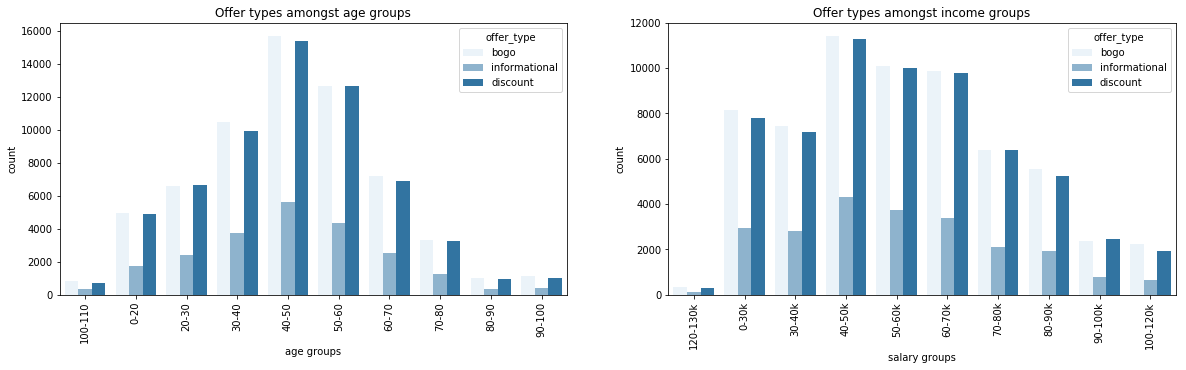

In [120]:
# Graph for Offer types amongst ages, salary groups:

plt.figure(figsize = [20,5])
color = sb.color_palette()[0]

plt.subplot(1,2,1)
x = sb.countplot(data = new_data, x = 'age_groups', hue = 'offer_type', color = color);
plt.title('Offer types amongst age groups');
plt.ylabel('count');
plt.xlabel('age groups');
xlabels = ['100-110', '0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

plt.subplot(1,2,2)
x = sb.countplot(data = new_data, x = 'salary_groups', hue = 'offer_type', color = color);
plt.title('Offer types amongst income groups');
plt.ylabel('count');
plt.xlabel('salary groups');
xlabels = ['120-130k', '0-30k', '30-40k', '40-50k', '50-60k', '60-70k', '70-80k', '80-90k', '90-100k', '100-120k']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 90);

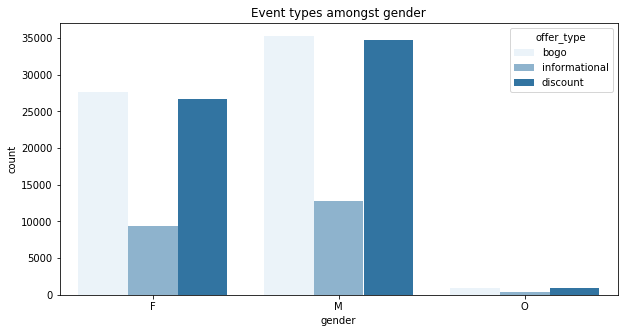

In [121]:
# Graph for event types amongst gender:

plt.figure(figsize = [10,5])
color = sb.color_palette()[0]

sb.countplot(data = new_data, x = 'gender', hue = 'offer_type', color = color);
plt.title('Event types amongst gender');
plt.ylabel('count');
plt.xlabel('gender');

#### We can see from the above graphs that, Bogo is slightly more popular amongst the ages, gender and income groups.

40-50 age group is more respondent to these offers than the otheer groups

Also, for the income distribution, the informational offer is almost round 50% than the other two.

Most male are respondents of these offers than the females with BOGO its leading type

To sum up, the active starbucks customer respondents are from the age group of 40-50, with higher male percentage having and annual income of 40-50k.

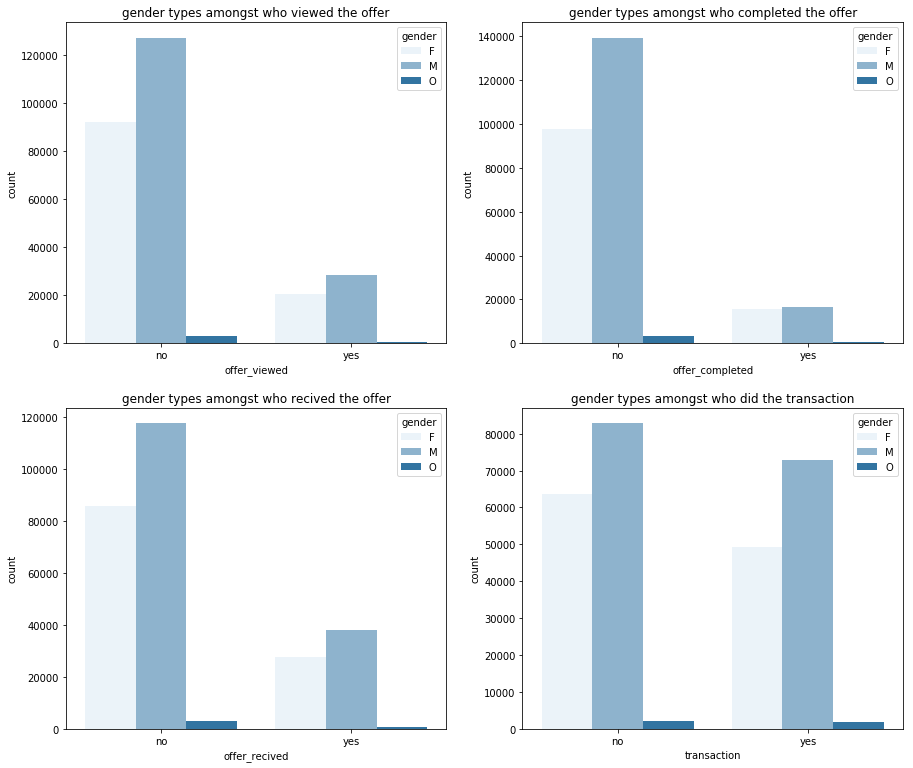

In [122]:
# Graph for gender amongst event types:

plt.subplots(2, 2, figsize=(15, 13))
color = sb.color_palette()[0]

plt.subplot(2,2,1)
x = sb.countplot(data = new_data, x = 'offer_viewed', hue = 'gender', color = color);
plt.title('gender types amongst who viewed the offer');
plt.ylabel('count');
plt.xlabel('offer_viewed');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(2,2,2)
x = sb.countplot(data = new_data, x = 'offer_completed', hue = 'gender', color = color);
plt.title('gender types amongst who completed the offer');
plt.ylabel('count');
plt.xlabel('offer_completed');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(2,2,3)
x = sb.countplot(data = new_data, x = 'offer_recived', hue = 'gender', color = color);
plt.title('gender types amongst who recived the offer');
plt.ylabel('count');
plt.xlabel('offer_recived');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

plt.subplot(2,2,4)
x = sb.countplot(data = new_data, x = 'transaction', hue = 'gender', color = color);
plt.title('gender types amongst who did the transaction');
plt.ylabel('count');
plt.xlabel('transaction');
xlabels = ['no', 'yes']
x.set_xticklabels(xlabels);
plt.xticks(rotation = 0);

# Modeling

## Supervised Learning:

* The y column is offer_type. It will help to predict the correct offer_type to send to each customer.

In [123]:
offer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148805 entries, 0 to 148804
Data columns (total 26 columns):
offer_completed          148805 non-null uint8
offer_recived            148805 non-null uint8
offer_viewed             148805 non-null uint8
event                    148805 non-null object
time                     148805 non-null int64
offer_id                 148805 non-null int64
age                      148805 non-null int64
became_member_on         148805 non-null datetime64[ns]
gender                   148805 non-null int64
income                   148805 non-null int64
age_groups               148805 non-null int64
salary_groups            148805 non-null int64
member_year              148805 non-null int64
member_month             148805 non-null int64
member_day               148805 non-null int64
members_since_in_days    148805 non-null int64
member_since_year        148805 non-null int64
difficulty               148805 non-null float64
duration                 148805

In [124]:
# Split data:

y = offer_df['offer_type']
X = offer_df.drop(['member_month', 'member_since_year', 'member_day', 'offer_type', 'offer_id', 'customer_ids', 'age_groups', 'salary_groups', 'members_since_in_days', 'became_member_on', 'event'],  axis =1 )

In [125]:
y.head()

0    0
1    0
2    0
3    2
4    2
Name: offer_type, dtype: int64

In [126]:
X.head()

,offer_completed,offer_recived,offer_viewed,time,age,gender,income,member_year,difficulty,duration,reward_y,email,web,mobile,social
0,0,1,0,0,75,0,100000,2017,5.0,7.0,5.0,1.0,1.0,1.0,0.0
1,0,0,1,6,75,0,100000,2017,5.0,7.0,5.0,1.0,1.0,1.0,0.0
2,1,0,0,132,75,0,100000,2017,5.0,7.0,5.0,1.0,1.0,1.0,0.0
3,0,1,0,168,75,0,100000,2017,0.0,3.0,0.0,1.0,0.0,1.0,1.0
4,0,0,1,216,75,0,100000,2017,0.0,3.0,0.0,1.0,0.0,1.0,1.0


In [127]:
# Create training and testing sets:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [128]:
X_train.shape, y_train.shape

((119044, 15), (119044,))

In [129]:
print('X training data Shape:', X_train.shape)
print('y training data Shape:', y_train.shape)
print('X testing data Shape:', X_test.shape)
print('y testing data Shape:', y_test.shape)

X training data Shape: (119044, 15)
y training data Shape: (119044,)
X testing data Shape: (29761, 15)
y testing data Shape: (29761,)


### Metrics:

* Since we have few binomial outcomes (BOGO = 1, discount = 2, informational = 3), we can use Classification models.

* Since it is a classification problem, we will use accuracy and presicion score to evaluate my models.

* Comapre the correct predictions and total number of predicitons to determine the accuracy of the model and choose the best.

#####  Five different ML algorithms can be test on the datset :
1. Decision Trees
2. Logistic Regression
3. Nearest Neighbours (KNN)
4. Naive Bayes
5. Random Forest

In [130]:
from sklearn.metrics import fbeta_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 


# function for checking accuracy:
def predict_score(model, X_train, y_train, X_test, y_test):
    '''
    INPUT:
       - model: the learning algorithm to be trained and predicted
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
       
    OUTPUT:
        - Accuracy Scores and F Scores of the models
    '''
    
    results = {}
    
    # Fit the model to the training data:
    model.fit(X_train, y_train)
    
    # predict on the testing data:
    pred = model.predict(X_test)

    # Confusion matrix:
    confusion_matrix(pred, y_test)
    
    # Accuracy for testing data:
    results['accuracy'] = accuracy_score(pred, y_test)
    
    # F-score on testing data:
    results['f_score'] = fbeta_score(y_test, pred, beta = 0.5, average='weighted')
    
    results['precision'] = precision_score(y_test, pred, average='micro')
    
    results['recall'] = recall_score(y_test, pred, average='micro')  
    
    return results

##### Initializing random_state to arbitrary number 42 because the seed will be set common for LogisticRegression and RandomForestClassifier models.
##### For RandomForestClassifier, initializing 500 to n_estimators parameter (The number of trees in the forest) for better accuracy.
##### Default parameter settings were used for KNeighborsClassifier(), GaussianNB() and DecisionTreeClassifier() in this dataset.


In [131]:
# Initialize the models

log = LogisticRegression(random_state=42)
rfc = RandomForestClassifier(n_estimators = 500, random_state=42)
knc = KNeighborsClassifier()
gnb = GaussianNB() 
dtc = DecisionTreeClassifier()

In [132]:
# Collect results on the models:

results = {}
for model in [log, rfc, knc, gnb, dtc]:
    model_name = model.__class__.__name__
    results[model_name] = {}
    results[model_name] = predict_score(model, X_train, y_train, X_test, y_test)

In [133]:
results

{'LogisticRegression': {'accuracy': 1.0,
  'f_score': 1.0,
  'precision': 1.0,
  'recall': 1.0},
 'RandomForestClassifier': {'accuracy': 1.0,
  'f_score': 1.0,
  'precision': 1.0,
  'recall': 1.0},
 'KNeighborsClassifier': {'accuracy': 0.81721044319747316,
  'f_score': 0.82139146564634269,
  'precision': 0.81721044319747316,
  'recall': 0.81721044319747316},
 'GaussianNB': {'accuracy': 1.0,
  'f_score': 1.0,
  'precision': 1.0,
  'recall': 1.0},
 'DecisionTreeClassifier': {'accuracy': 1.0,
  'f_score': 1.0,
  'precision': 1.0,
  'recall': 1.0}}

In [134]:
# Display results:

for ele in results.items():
    print (ele[0])
    display(pd.DataFrame(ele[1], index=range(1)))

LogisticRegression


,accuracy,f_score,precision,recall
0,1.0,1.0,1.0,1.0


RandomForestClassifier


,accuracy,f_score,precision,recall
0,1.0,1.0,1.0,1.0


KNeighborsClassifier


,accuracy,f_score,precision,recall
0,0.81721,0.821391,0.81721,0.81721


GaussianNB


,accuracy,f_score,precision,recall
0,1.0,1.0,1.0,1.0


DecisionTreeClassifier


,accuracy,f_score,precision,recall
0,1.0,1.0,1.0,1.0


## Model Refinement:

#### Accuracy score, F1 score, recall score and  precisioni score is 100% for testing datasets for RandomForestClassifier,  LogisticRegression, GaussianNB, DecisionTreeClassifier which can lead to **overfitting**

### So, we choose KNeighborsClassifier.

#### It has good results of  0.81 on testing datasets.

#### Since we have few binomial outcomes ( BOGO = 1, discount = 2, informational = 3 ) we can use KNeighborsClassifier.

### Accuracy and precision and recall scores are same for KNeighborsClassifier, with (0.81). I will choose KNeighborsClassifier model for further refinement with GridSearchCV. 

#### Since accuracy and precision scores are in this model, will consider precision value as a optimal for this particular dataset for correct positive predictions.

## Hyper parameter tuning of KNeighborsClassifier to increase the accuracy:

* It is possible to improve the performance of the model from it base instance by tuning hyperparameters of that algorithm.

* We will define a range of values that would be evaluated in the hyper parameter space of the for KNeighborsClassifier model using GridSearchCV.

* {"n_neighbors" :list(range(20,30)), "p" : [1]} are the grid parameters that we are using in this data set.

* Initializing random_state to arbitrary number 42 because the seed will be set common for this model.

*  Here we are using the RepeatedStratifiedKFold class. And RepeatedKFold with an appropriate number of folds and repeats, such as 10 folds and three repeats.

In [135]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


model = KNeighborsClassifier()

para_grid = {"n_neighbors" :list(range(20,30)), 
             "p" : [1]}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

grid_search = GridSearchCV(estimator = model, param_grid = para_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

y_pred = grid_result.predict(X_test)
accuracy_score(y_pred, y_test)

0.89167030677732606

In [136]:
# Confusion matrix:

confusion_matrix(y_pred, y_test)

array([[11778,  1399,   498],
       [ 1000, 11039,   320],
       [    7,     0,  3720]])

In [137]:
print(classification_report(y_test,y_pred,target_names = offer_df.columns))

                       precision    recall  f1-score   support

      offer_completed       0.86      0.92      0.89     12785
        offer_recived       0.89      0.89      0.89     12438
         offer_viewed       1.00      0.82      0.90      4538

          avg / total       0.90      0.89      0.89     29761



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 3, does not match size of target_names, 26
  .format(len(labels), len(target_names))


In [138]:
# find the best parameter values:

best_parameters = grid_result.best_params_
best_parameters

{'n_neighbors': 21, 'p': 1}

### the final model parameters that we have selected for this data set are {'n_neighbors' = 21, 'p' = 1}

In [139]:
# instantiate model with best parameters:

predict_score(KNeighborsClassifier(n_neighbors = 21, p = 1), X_train, y_train, X_test, y_test)

{'accuracy': 0.89167030677732606,
 'f_score': 0.89353964068453828,
 'precision': 0.89167030677732606,
 'recall': 0.89167030677732606}

### The best scores achieved after tuning, its essential hyper-parameters {'n_neighbors' = 21, 'p' = 1} by KNeighborsClassifier : testing accuracy is 0.89 (89%)

## Testing accuracy has increased after hyperparameter tunning.

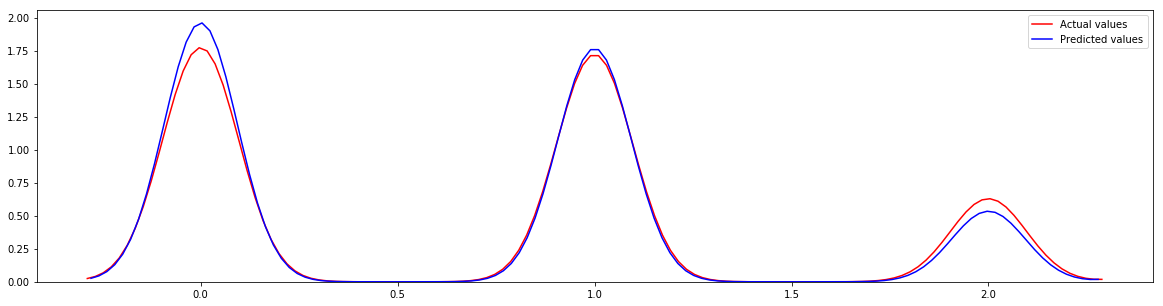

In [140]:
# Graph to display actual and predict values:

plt.figure(figsize=[20,5])
ax1 = sb.kdeplot(data=y_test, color="r", label='Actual values')
ax2 = sb.kdeplot(data=y_pred, color="b", label='Predicted values')
plt.legend();

## Evalute the model accuracy:


In [141]:
X.columns

Index(['offer_completed', 'offer_recived', 'offer_viewed', 'time', 'age',
       'gender', 'income', 'member_year', 'difficulty', 'duration', 'reward_y',
       'email', 'web', 'mobile', 'social'],
      dtype='object')

In [142]:
X.iloc[2275,:]

offer_completed        0.0
offer_recived          1.0
offer_viewed           0.0
time                 576.0
age                   66.0
gender                 0.0
income             32000.0
member_year         2018.0
difficulty            10.0
duration               7.0
reward_y              10.0
email                  1.0
web                    0.0
mobile                 1.0
social                 1.0
Name: 2275, dtype: float64

In [143]:
y.iloc[2275]

0

In [144]:
le_2.inverse_transform([0, 1, 2])

array(['bogo', 'discount', 'informational'], dtype=object)

## Now lets evaluate our model to check its accuracy:

In [145]:
customer_data = [0.0, 1.0, 0.0, 576.0, 66.0, 0.0, 32000.0, 2018.0, 10.0, 7.0, 10.0, 1.0, 0.0, 1.0, 1.0]

In [146]:
grid_result.predict([customer_data])

array([0])

In [147]:
X.iloc[2,:]

offer_completed         1.0
offer_recived           0.0
offer_viewed            0.0
time                  132.0
age                    75.0
gender                  0.0
income             100000.0
member_year          2017.0
difficulty              5.0
duration                7.0
reward_y                5.0
email                   1.0
web                     1.0
mobile                  1.0
social                  0.0
Name: 2, dtype: float64

In [148]:
y.iloc[2275]

0

In [149]:
customer_data1 = [1.0, 0.0, 0.0, 132.0, 75.0, 0.0, 100000.0, 2017.0, 5.0, 7.0, 5.0, 1.0, 1.0, 1.0, 0.0]

In [150]:
grid_result.predict([customer_data1])

array([1])

In [151]:
clf_1 = KNeighborsClassifier(n_neighbors = 21, p = 1)
clf_1.fit(X_train, y_train)

y_p = clf_1.predict(X_test)

print(classification_report(y_p, y_test))
accuracy_score(y_p, y_test)
precision_score(y_p, y_test, average='micro')

             precision    recall  f1-score   support

          0       0.92      0.86      0.89     13675
          1       0.89      0.89      0.89     12359
          2       0.82      1.00      0.90      3727

avg / total       0.89      0.89      0.89     29761



0.89167030677732606

#### The model has correctly predicted that the customer will likely respond tor BOGO offer type with an accuracy of 89%.

* Hence our model has good accuracy for prediction.

### KNeighborsClassifier turned out to be the best algorithm for this task and predicts customer response with an accuracy rate of almost 89% after hyperarameter tuning. Given the fact that also the same customer will react differently the same offer.

## Unsupervised Learning:

# KMeans Cluster:

* KMeans Clustering is applied on the data to find groups of customers and identify the factors affecting reactions of customers to different offers.


In [152]:
new_df = offer_df.copy()

new_df.drop(['became_member_on', 'event'], axis = 1, inplace = True)

* The elbow method will be used to determine the number of clusters for the data set.


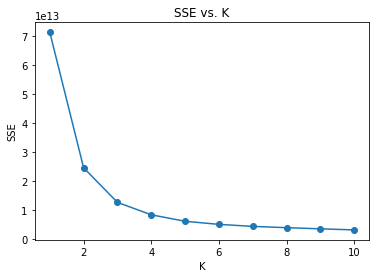

In [153]:
from sklearn.cluster import KMeans

wcss = []
for ele in range(1,11):
    k = KMeans(n_clusters = ele, init='k-means++', random_state=42)
    k.fit(new_df)
    wcss.append(k.inertia_)
    
#Plot the Figure:    
plt.plot(range(1,11), wcss, marker = 'o')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K');

The Graph makes an elbow at 2.

Number of optimal clusters for the dataset is 2

In [154]:
k = KMeans(n_clusters = 2, init='k-means++', random_state=42)
new = k.fit_predict(new_df)
new

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [155]:
# add new column cluster to data:

new_df['cluster'] = pd.Series(new, index=new_df.index)
new_df.head()

,offer_completed,offer_recived,offer_viewed,time,offer_id,age,gender,income,age_groups,salary_groups,...,difficulty,duration,offer_type,reward_y,email,web,mobile,social,customer_ids,cluster
0,0,1,0,0,6,75,0,100000,7,8,...,5.0,7.0,0,5.0,1.0,1.0,1.0,0.0,1,1
1,0,0,1,6,6,75,0,100000,7,8,...,5.0,7.0,0,5.0,1.0,1.0,1.0,0.0,1,1
2,1,0,0,132,6,75,0,100000,7,8,...,5.0,7.0,0,5.0,1.0,1.0,1.0,0.0,1,1
3,0,1,0,168,5,75,0,100000,7,8,...,0.0,3.0,2,0.0,1.0,0.0,1.0,1.0,1,1
4,0,0,1,216,5,75,0,100000,7,8,...,0.0,3.0,2,0.0,1.0,0.0,1.0,1.0,1,1


In [156]:
# Groupby cluster data to find mean values:

c_group = new_df.groupby('cluster').mean()
c_group

,offer_completed,offer_recived,offer_viewed,time,offer_id,age,gender,income,age_groups,salary_groups,...,member_since_year,difficulty,duration,offer_type,reward_y,email,web,mobile,social,customer_ids
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.194098,0.463077,0.342825,353.801946,4.75702,50.589461,0.668575,50666.458231,4.724564,3.527772,...,4.214409,7.766327,6.593670,0.732561,4.392910,1.0,0.800996,0.922101,0.667661,7085.131062
1,0.248347,0.426408,0.325244,355.543460,4.67148,60.086860,0.482558,86362.931481,5.504951,7.086997,...,4.241523,8.047939,6.665159,0.711574,4.505195,1.0,0.814033,0.910901,0.646467,7117.315069


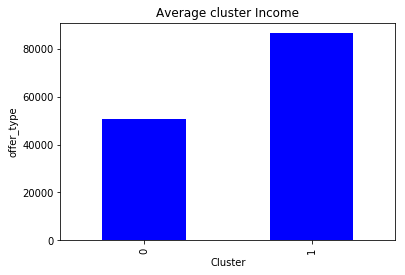

In [157]:
# Plot cluster wrt income:

c_group.income.plot(kind = 'bar', color = 'b')
plt.xlabel('Cluster')
plt.ylabel('offer_type')
plt.title('Average cluster Income');

In [158]:
# Transpose form:

trans = c_group.T
trans

cluster,0,1
offer_completed,0.194098,0.248347
offer_recived,0.463077,0.426408
offer_viewed,0.342825,0.325244
time,353.801946,355.543460
offer_id,4.757020,4.671480
age,50.589461,60.086860
gender,0.668575,0.482558
income,50666.458231,86362.931481
age_groups,4.724564,5.504951
salary_groups,3.527772,7.086997


In [159]:
# Mean values:

mean_val = c_group.mean()
mean_val

offer_completed              0.221223
offer_recived                0.444743
offer_viewed                 0.334035
time                       354.672703
offer_id                     4.714250
age                         55.338160
gender                       0.575566
income                   68514.694856
age_groups                   5.114757
salary_groups                5.307385
member_year               2016.574828
member_month                 6.710187
member_day                  15.891501
members_since_in_days     1725.598478
member_since_year            4.227966
difficulty                   7.907133
duration                     6.629414
offer_type                   0.722067
reward_y                     4.449052
email                        1.000000
web                          0.807514
mobile                       0.916501
social                       0.657064
customer_ids              7101.223065
dtype: float64

In [160]:

# calculate difference in mean to check different clusters:

data = (c_group - mean_val) *100 / mean_val
data

,offer_completed,offer_recived,offer_viewed,time,offer_id,age,gender,income,age_groups,salary_groups,...,member_since_year,difficulty,duration,offer_type,reward_y,email,web,mobile,social,customer_ids
cluster,,,,,,,,,,,,,,,,,,,,,
0,-12.26121,4.122435,2.631566,-0.24551,0.907242,-8.581238,16.15945,-26.050232,-7.628779,-33.530874,...,-0.320653,-1.780745,-0.539178,1.45321,-1.261893,0.0,-0.80724,0.611027,1.612729,-0.226609
1,12.26121,-4.122435,-2.631566,0.24551,-0.907242,8.581238,-16.15945,26.050232,7.628779,33.530874,...,0.320653,1.780745,0.539178,-1.45321,1.261893,0.0,0.80724,-0.611027,-1.612729,0.226609


In [161]:
# Transpose:

df = data.T
df

cluster,0,1
offer_completed,-12.261210,12.261210
offer_recived,4.122435,-4.122435
offer_viewed,2.631566,-2.631566
time,-0.245510,0.245510
offer_id,0.907242,-0.907242
age,-8.581238,8.581238
gender,16.159450,-16.159450
income,-26.050232,26.050232
age_groups,-7.628779,7.628779
salary_groups,-33.530874,33.530874


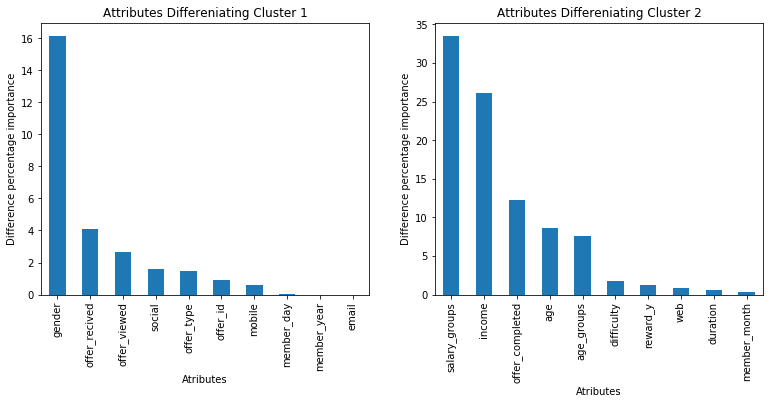

In [162]:
# Plot attributes associated with data:
color = sb.color_palette()[0]

plt.figure(figsize=[20,5])
plt.subplot(1,3,1)
df[0].sort_values(ascending=False).head(10).plot(kind = 'bar', color = color)
plt.xlabel('Atributes')
plt.ylabel('Difference percentage importance')
plt.title('Attributes Differeniating Cluster 1');

plt.subplot(1,3,2)
df[1].sort_values(ascending=False).head(10).plot(kind = 'bar', color = color)
plt.xlabel('Atributes')
plt.ylabel('Difference percentage importance')
plt.title('Attributes Differeniating Cluster 2');


From the above graph, the top attributes associated with offer_type are:
* income
* events
* gender
* age

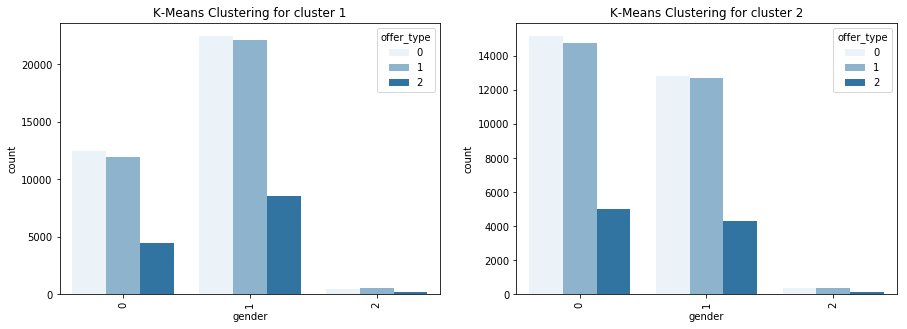

In [163]:
plt.figure(figsize = (15,5))

color = sb.color_palette()[0]

plt.subplot(1,2,1)
x = sb.countplot(data = new_df[new_df['cluster'] == 0], x = 'gender', hue = 'offer_type', color = color);
plt.title('K-Means Clustering for cluster 1');
plt.ylabel('count');
plt.xlabel('gender');
plt.xticks(rotation = 90);

plt.subplot(1,2,2)
x = sb.countplot(data = new_df[new_df['cluster'] == 1], x = 'gender', hue = 'offer_type', color = color);
plt.title('K-Means Clustering for cluster 2');
plt.ylabel('count');
plt.xlabel('gender');
plt.xticks(rotation = 90);

plt.show();

Compared to BOGO and Discount offer, the informational offers are very less popular.

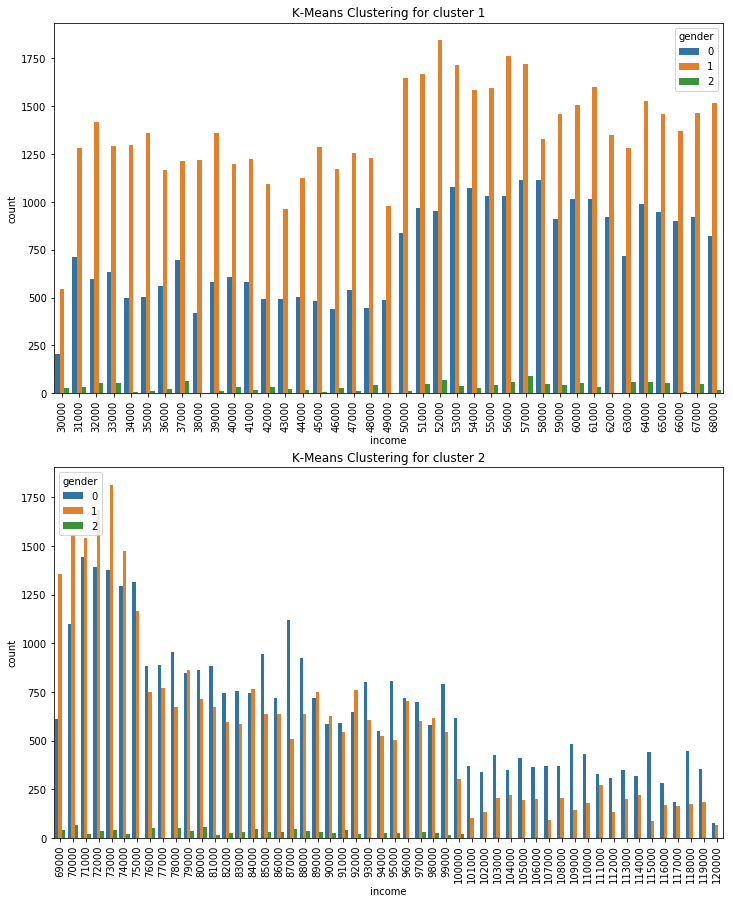

In [164]:
fig, ax = plt.subplots(2,2, figsize=(12, 15))

plt.subplot(2,1,1)
x = sb.countplot(data = new_df[new_df['cluster'] == 0], x = 'income', hue = 'gender');
plt.title('K-Means Clustering for cluster 1');
plt.ylabel('count');
plt.xlabel('income');
plt.xticks(rotation = 90);

plt.subplot(2,1,2)
x = sb.countplot(data = new_df[new_df['cluster'] == 1], x = 'income', hue = 'gender');
plt.title('K-Means Clustering for cluster 2');
plt.ylabel('count');
plt.xlabel('income');
plt.xticks(rotation = 90);

plt.show();

In [165]:
le_3.inverse_transform([0, 1, 2])

array(['F', 'M', 'O'], dtype=object)

In [166]:
print("Income Range for Cluster 0:", new_df[new_df['cluster']==0]['income'].min(), 
      "to", new_df[new_df['cluster']==0]['income'].max())

print("Income Range for Cluster 1:", new_df[new_df['cluster']==1]['income'].min(), 
      "to", new_df[new_df['cluster']==1]['income'].max())


Income Range for Cluster 0: 30000 to 68000
Income Range for Cluster 1: 69000 to 120000


Compared to BOGO and Discount offer, the informational offers are less popular.

Few cases the Discount Offers are used more than the BOGO offers:
In cluster1 at income = 51000, income = 52000, in cluster2 at income = 76000, income = 77000

Since the income is unevenly distributed, it can also be concluded that the annual income is indepedent of the purchasing behavior

For Cluster 0, the income ranges from 3000.0 to 68000.0.
It can thus be concluded that males with the above income range tend to spend more than females and other Genders for the BOGO and Discount Offers.

For Cluster 1, the income ranges from 69000.0 to 120000.0.
It can thus be concluded that females with income range 75000 to 120000 tend to spend more than males and other Genders for the BOGO and Discount Offers.

# Conclusion:

On analysis the data using supervised and unsupervised learning(Kmeans), we can conclude that:
* Different segments of customers react to offers differently.
* The count of male customers in low-income level is slightly higher than that of female and other customers
* Though the average salary of female is greater than that of the male, female spend less on Starbucks than male
* Starbucks has more of the young crowd than those of the aged once.
* The result of the offer_type was predicted by training a supervised classifier.

## Results:
* Customers are attracted to BOGO and Discount offers more as compared to Informational Offers
* The buying behavior of a customer is independent of its annual income
* Starbucks have more male customers than females and other gender.

## KNeighborsClassifier turned out to be the best algorithm for this task and predicts customer response with an accuracy rate and precision rate of almost 89% after hyperarameter tuning. Given the fact that also the same customer will react differently the same offer. So will choose  KNeighborsClassifier is best algorithm for this dataset.

## Improvement:

I think I got good results for the prediction model. 

I completely understood the data provided by Starbucks.

I believe that the idea of improving the data collection or fixing issues related with the missing data or NaNs would be really helpful. 

In my opinion, I think that we can get great insights from this data set and great prediction models might be also built to solve problems statements associated with this data set. 

Examples for these model are the following :
Building a model that can predict which kind of offers to be sent to which customer? 

## Reflection:

I thoroughly enjoyed working on this project which allowed me to polish my skills in Data Preprocessing and Modeling. 

The most difficult part in my opinion was understanding the dataset.

The Preprocessing step was the longest and most challenging part to complete. 

The Dataset itself is inspiring.